In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

Stations = pd.read_csv('hubway_stations.csv')

In [2]:
Stations.head()

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing


In [3]:
Trips = pd.read_csv('hubway_trips.csv')

In [4]:
Trips.head()

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female


In [5]:
Trips.dtypes

seq_id          int64
hubway_id       int64
status         object
duration        int64
start_date     object
strt_statn    float64
end_date       object
end_statn     float64
bike_nr        object
subsc_type     object
zip_code       object
birth_date    float64
gender         object
dtype: object

In [6]:
registered_members_duration = np.array(Trips['duration'].loc[Trips['subsc_type'] == 'Registered'])

In [7]:
registered_members_duration

array([  9, 220,  56, ..., 480, 120, 420], dtype=int64)

In [8]:
casual_members_duration = np.array(Trips['duration'].loc[Trips['subsc_type'] == 'Casual'])

In [9]:
casual_members_duration

array([ 994, 2121, 1315, ...,  780,  300,  540], dtype=int64)

In [10]:
np.mean(registered_members_duration)

733.3289835450383

In [11]:
np.mean(casual_members_duration)

2293.4422135752234

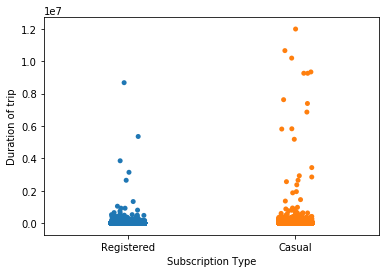

In [12]:
sns.stripplot(x='subsc_type',y='duration', data=Trips)
plt.ylabel('Duration of trip')
plt.xlabel('Subscription Type')
plt.show()

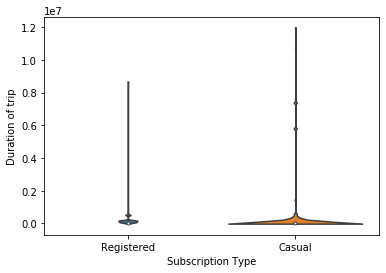

In [13]:
sns.violinplot(x='subsc_type',y='duration', data=Trips)
plt.ylabel('Duration of trip')
plt.xlabel('Subscription Type')
plt.show()

# Conclusion

With this we can conclude that Casual members tend to have (on average) longer trips than Registered members.

Registered trip mean (seconds): 733.3289835450383

Casual trip mean (seconds): 2293.4422135752234

But this might not be the most accurate representation of time of trips since we have a large amount of outliers.

In [14]:
Trips['start_date'] = pd.to_datetime(Trips['start_date'], format='%m/%d/%Y %H:%M:%S')
# Turned the start date column into a datetime

In [15]:
Trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579025 entries, 0 to 1579024
Data columns (total 13 columns):
seq_id        1579025 non-null int64
hubway_id     1579025 non-null int64
status        1579025 non-null object
duration      1579025 non-null int64
start_date    1579025 non-null datetime64[ns]
strt_statn    1579011 non-null float64
end_date      1579025 non-null object
end_statn     1578980 non-null float64
bike_nr       1578559 non-null object
subsc_type    1579025 non-null object
zip_code      1106259 non-null object
birth_date    350644 non-null float64
gender        1106414 non-null object
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 156.6+ MB


In [16]:
Trips_initial_time = Trips.set_index('start_date').resample('H').count()

In [17]:
Trips_initial_time = Trips_initial_time['duration']

In [18]:
Trips_per_hour=Trips_initial_time.groupby(Trips_initial_time.index.hour).sum()
#Added up all of the counts of trips from each hour of the day individualy
Trips_per_hour.index.name = 'Hour'
Trips_per_hour=Trips_per_hour.rename('Trip Count')

In [19]:
Trips_per_hour

Hour
0      17826
1      14344
2      10488
3       3056
4       2201
5       7189
6      26780
7      73784
8     128053
9      79240
10     62413
11     74369
12     91815
13     92826
14     91745
15     99831
16    130762
17    176240
18    129882
19     91460
20     62231
21     47600
22     38063
23     26827
Name: Trip Count, dtype: int64

In [20]:
Trips_per_hour.max()

176240

Text(0, 0.5, 'Trips')

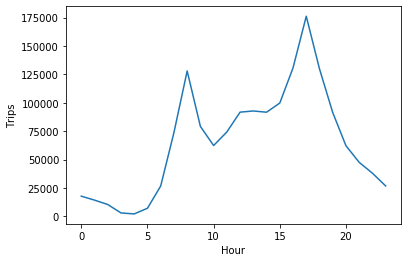

In [21]:
plt.plot(Trips_per_hour)
plt.xlabel('Hour')
plt.ylabel('Trips')

# Conclusion

This graph shows the sum of all trips each hour throughout the whole dataset.

The highest peak is at hour 17 (5 PM)

The second highest peak is at hour 8 (8 AM)

This makes sense since, judging by my own experience taking the Metro bus to college, the peak hours tend to always be early in the morning and late afternoon.

In [22]:
Trips['end_date'] = pd.to_datetime(Trips['end_date'], format='%m/%d/%Y %H:%M:%S')

In [23]:
Trips_final_day = Trips.set_index('end_date').resample('D').count()

In [24]:
Trips_final_day = Trips_final_day['duration']

In [25]:
Trips_per_days_week=Trips_final_day.groupby(Trips_final_day.index.dayofweek).sum()
#Grouping by day of week in order and getting the net trips per day

In [26]:
Trips_per_days_week.index.name = 'Day'
Trips_per_days_week = Trips_per_days_week.rename('Trips')
Trips_per_days_week

Day
0    230549
1    231785
2    238615
3    234869
4    230906
5    215591
6    196710
Name: Trips, dtype: int64

In [27]:
days = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
Trips_per_days_week.index = days

In [28]:
Trips_per_days_week

Monday       230549
Tuesday      231785
Wednesday    238615
Thursday     234869
Friday       230906
Saturday     215591
Sunday       196710
Name: Trips, dtype: int64

In [29]:
Trips_per_days_week[Trips_per_days_week == Trips_per_days_week.max()]

Wednesday    238615
Name: Trips, dtype: int64

Text(0.5, 0, 'Day')

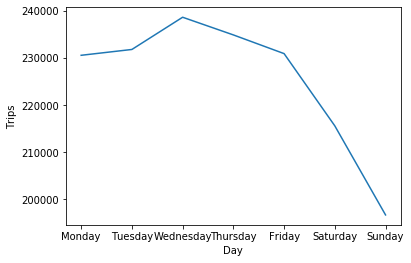

In [30]:
plt.plot(Trips_per_days_week)
plt.ylabel('Trips')
plt.xlabel('Day')

# Conclusion

This graph shows the sum of the number of trips each day on the whole dataset.

The day with the most trips seems to be Wednesday.
In general, Monday through Friday tend to have the most traffic; Sunday seems to have the least traffic and Saturday is in between.

In [31]:
Trips_by_startstation = Trips.groupby('strt_statn')
aggregator = {'duration': 'count'}

In [32]:
aggregated_startstation = Trips_by_startstation.aggregate(aggregator)

In [33]:
aggregated_startstation.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 142 entries, 3.0 to 145.0
Data columns (total 1 columns):
duration    142 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [34]:
aggregated_startstation.duration.sum()
#Corroborating the count. I see the 14 missing values of the startstation column

1579011

In [35]:
aggregated_startstation = aggregated_startstation.rename(columns={'duration':'Trips'}) 
#Renamed it to trips since it is not the sum of duration
aggregated_startstation.sort_values(by='Trips', ascending=0).head()

,Trips
strt_statn,
22.0,56443
36.0,42571
53.0,35440
67.0,33685
16.0,32860


Text(0, 0.5, 'Trips')

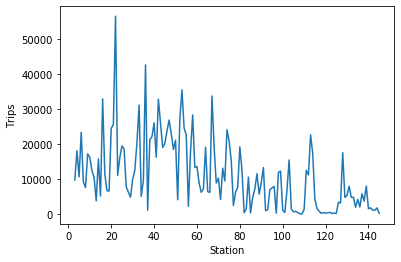

In [36]:
plt.plot(aggregated_startstation)
plt.xlabel('Station')
plt.ylabel('Trips')

In [37]:
aggregated_startstation.index = aggregated_startstation.index.astype(int)
#Turning the floats index into int intex to merge them with the Stations dataframe
aggregated_startstation.head()

,Trips
strt_statn,
3,9734
4,18058
5,10630
6,23322
7,9163


In [38]:
Stations = Stations.set_index('id')
# Changed the index of stations dataframe to merge it with aggregated_startstation

In [39]:
Stations_merge = pd.concat([Stations,aggregated_startstation],axis=1, sort = True)
#Merging the Stations DF with the aggregated DF to see the name of the stations

In [40]:
Stations_merge.sort_values(by='Trips', ascending=0).head()

,terminal,station,municipal,lat,lng,status,Trips
22,A32010,South Station - 700 Atlantic Ave.,Boston,42.352175,-71.055547,Existing,56443
36,D32005,Boston Public Library - 700 Boylston St.,Boston,42.349673,-71.077303,Existing,42571
53,B32016,Beacon St / Mass Ave,Boston,42.350851,-71.089886,Existing,35440
67,M32006,MIT at Mass Ave / Amherst St,Cambridge,42.358100,-71.093198,Existing,33685
16,C32003,Back Bay / South End Station,Boston,42.347433,-71.076163,Existing,32860


# Conclusion

I ignored the 14 missing values in the strt_statn column since they are statistically insignificant compared to the size of the dataset.

South Station - 700 Atlantic Ave. seems to be the most popular having 56443 total trips counted.

The second most popular is station Boston Public Library - 700 Boylston St.having 42571 total trips.

The third one is station Beacon St / Mass Ave with 35440 total trips taken.

These answers might not be the most accurate since im not taking into consideration the trip times/duration, only how many trips.
I'm also only using start stations as reference and not end stations jusging by where the section of the question lies (Start Station)

In [41]:
Trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579025 entries, 0 to 1579024
Data columns (total 13 columns):
seq_id        1579025 non-null int64
hubway_id     1579025 non-null int64
status        1579025 non-null object
duration      1579025 non-null int64
start_date    1579025 non-null datetime64[ns]
strt_statn    1579011 non-null float64
end_date      1579025 non-null datetime64[ns]
end_statn     1578980 non-null float64
bike_nr       1578559 non-null object
subsc_type    1579025 non-null object
zip_code      1106259 non-null object
birth_date    350644 non-null float64
gender        1106414 non-null object
dtypes: datetime64[ns](2), float64(3), int64(3), object(5)
memory usage: 156.6+ MB


In [42]:
#Using the Trips dataframe and dropping nans from start station and end station
#Turning them from floats to Ints
Trips_dropped=Trips.dropna(subset=['strt_statn', 'end_statn']).copy()
Trips_dropped[['strt_statn', 'end_statn']] = Trips_dropped[['strt_statn', 'end_statn']].applymap(np.int64)#grouped_start_end=Trips_dropped.groupby(['strt_statn', 'end_statn']).aggregate(aggregator)

grouped_start_end=Trips_dropped.groupby(['strt_statn', 'end_statn']).aggregate(aggregator)
grouped_start_end = grouped_start_end.rename(columns={'duration':'Trips'}) 

In [43]:
grouped_start_end.head()

Trips
strt_statn end_statn       
3          3            472
           4            165
           5            289
           6            100
           7              4

In [44]:
grouped_start_end['Trips'].sum()

1578973

In [45]:
grouped_start_end.sort_values(by='Trips', ascending=0).head(6)

,,Trips
strt_statn,end_statn,
53,67,5185
67,53,4993
40,22,4384
22,40,4208
58,58,3126
22,43,3067


(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text xticklabel objects>)

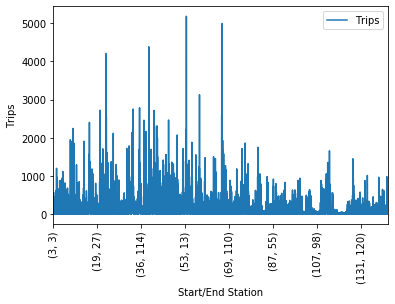

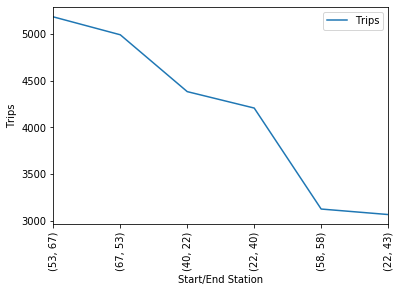

In [46]:
grouped_start_end.plot()
plt.ylabel("Trips")
plt.xlabel('Start/End Station')
plt.xticks(rotation='vertical')
grouped_start_end.sort_values(by='Trips', ascending=0).head(6).plot()
plt.ylabel("Trips")
plt.xlabel('Start/End Station')
plt.xticks(rotation='vertical')

In [47]:
grouped_start_end.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15233 entries, (3, 3) to (145, 145)
Data columns (total 1 columns):
Trips    15233 non-null int64
dtypes: int64(1)
memory usage: 180.9 KB


# Conclusion

There are only 45 missing values from end station which I did not bother filling since they would also be statistically insignificant. In total, there are 52 missing values, combining the ones from start station and end station.

The most popular combination of start/end stations looks to be 53/67 with 5185 net trips.

Inversely, 67/53 has 4993 net trips. Which makes sense since almost the same amount of people tend to return via the same transportation method.

Then there is 40/22 and 22/40 with 4384 and 4208 trips respectively.

A cool thing we can notice here is that in station 58, people start and end there oftenly so I can assume that station is mostly used for entertainment rather than for transportation.

In [48]:
aggregated_startstation = aggregated_startstation.sort_index()
aggregated_startstation.head()

,Trips
strt_statn,
3,9734
4,18058
5,10630
6,23322
7,9163


In [49]:
Trips_by_endstation = Trips.groupby('end_statn')
aggregated_endstation = Trips_by_endstation.aggregate(aggregator)
aggregated_endstation = aggregated_endstation.rename(columns={'duration':'Trips'})
aggregated_endstation.index = aggregated_endstation.index.astype(int)

In [50]:
aggregated_endstation = aggregated_endstation.sort_index()
aggregated_endstation.head()

,Trips
end_statn,
3,9260
4,17472
5,11058
6,22655
7,8883


In [51]:
aggregated_endstation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 3 to 145
Data columns (total 1 columns):
Trips    142 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [52]:
aggregated_startstation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 3 to 145
Data columns (total 1 columns):
Trips    142 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [53]:
Difference = aggregated_endstation - aggregated_startstation
Difference.index.names = ['Station']

In [54]:
Difference.sort_values(by='Trips', ascending=0).head()
#More people tend to end their trips here

,Trips
Station,
74,2685
42,2118
114,1756
43,1686
10,1618


In [55]:
Difference.sort_values(by='Trips', ascending=1).head()
#More people tend to start here

,Trips
Station,
16,-3195
53,-2071
25,-2014
58,-1929
20,-1650


In [56]:
Difference[(Difference.Trips >=-20) & (Difference.Trips <=20)]
#Stable frequency of startstation and endstation

,Trips
Station,
85,19
91,-11
97,-11
102,-2
106,-9
108,-17
109,-7
115,-20
117,0


Text(0.5, 0, 'Station')

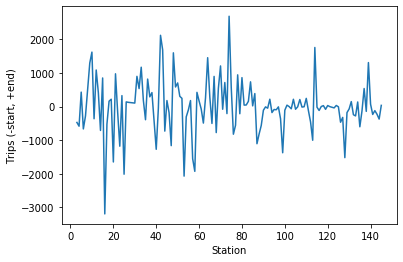

In [57]:
plt.plot(Difference)
plt.ylabel('Trips (-start, +end)')
plt.xlabel('Station')

# Conclusion

This graph shows the difference in trips between starting stations and end stations. Near Zero means that the same amount trips that are started there are about the same amounts of trips that are ended there. The higher the peak (+) means that more trips end there than they start there. The lower (-) peaks mean that more trips start there than end there.

As seen in the table, station 16 in which most people start at, but not many people tend to finish their trip there.

Station 74 in the other hand, has a lot of people that end there but not many people that start there.

In addition, I did find a difference of 0 in station 117 meaning that station tends to be very stable as a destination and a starting zone. Although we do have 52 missing trips from the dropped NAN values which are not being considered, but they shouldnt all apply to station 117.

TLDR: Station 74 and 16 are the most asymetric.

In [65]:
Asymetric_stations = [74,16]
Asym_concat = pd.concat([Stations, Difference], axis=1, sort = True)

In [67]:
Asym_concat.loc[Asymetric_stations]

,terminal,station,municipal,lat,lng,status,Trips
74,M32018,Harvard Square at Mass Ave/ Dunster,Cambridge,42.373268,-71.118579,Existing,2685
16,C32003,Back Bay / South End Station,Boston,42.347433,-71.076163,Existing,-3195
